# Letal COVID-19 snRNA Analysis
# Section 4: Dimensionality Reduction
Author: MikiasHWT  
Start: December 9, 2024  

In [1]:
from datetime import datetime
current_date = datetime.now().strftime("%B %d, %Y")
print(f"Updated: {current_date}")

Updated: December 21, 2024


# Background

With the size of RNA sequencing experiments, we cant normally process all our samples at once. Instead we test and optimize our workflow with a representative sample, (or a control set), before we apply the same processes to the entire dataset. 

This dataset contains 27 samples of varying sizes. So we will ingest and integrate these samples into a single Anndata object and verify that there is little to no batch effect. 

We will apply the following steps:
- Read datafile
- Annotate sample name
- Calculate QC metrics
- Filter our genes expressed in less than 3 cells
- Detect and remove outliers
    - Outliers: Above 5 Median Absolute Deviations (MAD) of `total gene counts` and `unique gene counts`
- Normalize counts to median of all counts
- Apply default Pseudolog transformation 
- Identify highly variable genes (without a predefined number)
- Combine each sample into a single object


## Objective

- Integrate 27 sequencing samples into a single anndata object
    - On local computer or...
    - Through an AWS EC2 instance to unload the computational burden
- label each cell/observation with its sample of origin
- Optimize pipeline & code for performance
- Confirm proper integration
- Check for batch effects

# Prep Workspace

## Import Libraries

In [2]:
# Default 
import numpy as np  # Numerical computing library
import pandas as pd  # Data manipulation and analysis
import matplotlib.pyplot as plt  # Plotting and visualization
import seaborn as sns  # Statistical data visualization
import scanpy as sc  # Single-cell data analysis
import os  # Operating system interface

import anndata
from scipy.stats import median_abs_deviation  # Robust statistic for dispersion
from scipy.sparse import csr_matrix # Handle sparce matrix
from IPython.display import display, clear_output

# Memory
import cProfile
import psutil
import sys
import pdb # debugger


## Directories

In [3]:
# Define directories 
datDir = os.path.abspath("data")
outDir = os.path.abspath("output")

# Integrate

## Define Functions

In [4]:
# Create MAD function
def is_outlier(adata, qcmetric: str, madunits: int):
    """
    Identified outlier points using the Mean Absolute Deviation function from scipy

    Args:
        adata (_type_): Anndata object with RNA data
        qcmetric (str): QC metric to use for outlier detection
        madunits (int): Value of MAD units to use for the QC metric

    Returns:
        _type_: Boolean value identifying outliers
    """
    M = adata.obs[qcmetric]
    outlier = (M < np.median(M) - madunits * median_abs_deviation(M)) | (M > np.median(M) + madunits * median_abs_deviation(M))
    return outlier

In [29]:
# Need to Integrate then run pipeline. Because im loosing information

def process_and_integrate(data_dir):
    """
    Function: process_and_integrate

    This function processes and integrates single-cell RNA sequencing data from multiple files in a specified directory. 
    The function performs the following steps:
    1. Loads and transposes input data from `.csv.gz` files.
    2. Annotates mitochondrial, ribosomal, and hemoglobin genes for quality control (QC) metrics.
    3. Calculates QC metrics (e.g., log1p transformations, mitochondrial content).
    4. Filters out genes with low variance and cells flagged as outliers.
    5. Normalizes and log-transforms the data.
    6. Identifies highly variable genes.
    7. Converts the data to sparse matrix format to optimize memory usage.
    8. Combines the processed data into a single `AnnData` object.

    Parameters:
    - data_dir (str): Path to the directory containing `.csv.gz` files with gene expression data.

    Returns:
    - combined_adata (AnnData): An integrated `AnnData` object containing all processed data.

    Dependencies:
    - `scanpy` for data processing.
    - `anndata` for integration.
    - `scipy.sparse` for memory-efficient storage.
    """
    adata_list = []  # Initialize list 

    # Get a list of all `.csv.gz` files
    files = [file for file in os.listdir(data_dir) if file.endswith('.csv.gz')]
    total_samples = len(files)  # Count the total number of samples
    
    for i, file in enumerate(files, start=1):
        file_path = os.path.join(data_dir, file)
        try:
            # Clear output
            clear_output(wait=True)

            # Extract sample name
            sample_name = file.split("_")[1]

            # Print progress
            print(f"Loading {sample_name}: {i} of {total_samples}")
            
            # Load and transpose data
            adata = sc.read_csv(file_path).T

            # Assign sample name
            adata.obs["Sample"] = sample_name

            # Assign experimental groupings
            expt_group = 'Control' if 'ctr' in sample_name.lower() else ('Covid' if 'cov' in sample_name.lower() else 'Unknown')
            adata.obs["Group"] = expt_group

            print(f"{adata.X.shape[0]} cells, {adata.X.shape[1]} transcripts")
            
            # Calculate QC Metrics
            adata.var["mt"] = adata.var_names.str.startswith("MT-")
            adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
            adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))  
            sc.pp.calculate_qc_metrics(adata, 
                                       qc_vars=["mt", "ribo", "hb"], 
                                       inplace=True, 
                                       percent_top=[20], 
                                       log1p=True)

            # Filter low-variance genes
            sc.pp.filter_genes(adata, min_cells=3, inplace=True)

            # Remove outliers
            adata.obs["outlier"] = (
                is_outlier(adata, "log1p_total_counts", 5)
                | is_outlier(adata, "log1p_n_genes_by_counts", 5))
            adata = adata[~adata.obs["outlier"]].copy()  

            print("QC complete. Starting normalization.")

            # Save raw counts
            adata.layers["counts"] = csr_matrix(adata.X)
            sc.pp.normalize_total(adata, target_sum=None, inplace=True) # Normalize
            sc.pp.log1p(adata)  # Transform 
            adata.X = csr_matrix(adata.X) # Ensure sparse matrix

            # Identify highly variable genes
            sc.pp.highly_variable_genes(adata)

            print(f"Done\n")
            adata_list.append(adata)  # Add processed object to list
        
        except Exception as e:
            print(f"Error processing {file}: {e}")
            continue

    # Concatenate all AnnData objects
    combined_adata = anndata.concat(
        adata_list,
        join="outer", # including this looses var information
        merge="same",
        label="Sample",
        keys=[ad.obs["Sample"].iloc[0] for ad in adata_list]  # Validate keys explicitly
    )
    
    # Print final message
    clear_output(wait=True)
    print(f"All {total_samples} samples have been processed.")

    return combined_adata


## Check Memory

In [6]:
# test_dir = "data\\GSE171524_RAW\\Test_Subset"

#cProfile.run("process_and_integrate(test_dir)")

In [7]:
# Check Memory usage
print("RAM used:", psutil.virtual_memory().used / 1e9, "GB")

RAM used: 7.456149504 GB


## Integrate

In [30]:
combined_adata = process_and_integrate("data\\GSE171524_RAW")

All 27 samples have been processed.


In [9]:
combined_adata.obs

Sample    Group  n_genes_by_counts  \
CACTGAAGTCGAAGCA-1_1   C51ctr  Control               5487   
ACTGATGTCTGCACCT-1_1   C51ctr  Control               4411   
TTACCGCCACTCAGAT-1_1   C51ctr  Control               4144   
TTGGTTTTCCTAGCTC-1_1   C51ctr  Control               3902   
TGGGAAGTCAGTGATC-1_1   C51ctr  Control               4719   
...                       ...      ...                ...   
CCTAAGAAGTTGTCAC-1_27  L22cov    Covid                344   
CGTGAATCATGTCTAG-1_27  L22cov    Covid                350   
GCCGATGAGTAAACGT-1_27  L22cov    Covid                326   
AGGGTGAGTATCAGGG-1_27  L22cov    Covid                331   
ATGGATCAGAGAGCAA-1_27  L22cov    Covid                335   

                       log1p_n_genes_by_counts  total_counts  \
CACTGAAGTCGAAGCA-1_1                  8.610319       12725.0   
ACTGATGTCTGCACCT-1_1                  8.392083       12435.0   
TTACCGCCACTCAGAT-1_1                  8.329658       11369.0   
TTGGTTTTCCTAGCTC-1_1                  8.269501       11472.0   
TGGGAAGTCAGTGATC-1_1                  8.459564       11238.0   
...                                        ...           ...   
CCTAAGAAGTTGTCAC-1_27                 5.843544         413.0   
CGTGAATCATGTCTAG-1_27                 5.860786         402.0   
GCCGATGAGTAAACGT-1_27                 5.789960         401.0   
AGGGTGAGTATCAGGG-1_27                 5.805135         402.0   
ATGGATCAGAGAGCAA-1_27                 5.817111         403.0   

                       log1p_total_counts  pct_counts_in_top_20_genes  \
CACTGAAGTCGAAGCA-1_1             9.451403                    6.994106   
ACTGATGTCTGCACCT-1_1             9.428350                   13.228790   
TTACCGCCACTCAGAT-1_1             9.338734                    9.446741   
TTGGTTTTCCTAGCTC-1_1             9.347752                   13.406555   
TGGGAAGTCAGTGATC-1_1             9.327146                    7.145400   
...                                   ...                         ...   
CCTAAGAAGTTGTCAC-1_27            6.025866                   18.401937   
CGTGAATCATGTCTAG-1_27            5.998937                   14.179104   
GCCGATGAGTAAACGT-1_27            5.996452                   19.451372   
AGGGTGAGTATCAGGG-1_27            5.998937                   14.676617   
ATGGATCAGAGAGCAA-1_27            6.001415                   17.369727   

                       total_counts_mt  log1p_total_counts_mt  pct_counts_mt  \
CACTGAAGTCGAAGCA-1_1             355.0               5.874931       2.789784   
ACTGATGTCTGCACCT-1_1               0.0               0.000000       0.000000   
TTACCGCCACTCAGAT-1_1              39.0               3.688879       0.343038   
TTGGTTTTCCTAGCTC-1_1             463.0               6.139884       4.035913   
TGGGAAGTCAGTGATC-1_1              92.0               4.532599       0.818651   
...                                ...                    ...            ...   
CCTAAGAAGTTGTCAC-1_27             40.0               3.713572       9.685230   
CGTGAATCATGTCTAG-1_27              3.0               1.386294       0.746269   
GCCGATGAGTAAACGT-1_27              0.0               0.000000       0.000000   
AGGGTGAGTATCAGGG-1_27              1.0               0.693147       0.248756   
ATGGATCAGAGAGCAA-1_27              1.0               0.693147       0.248139   

                       total_counts_ribo  log1p_total_counts_ribo  \
CACTGAAGTCGAAGCA-1_1                95.0                 4.564348   
ACTGATGTCTGCACCT-1_1                21.0                 3.091043   
TTACCGCCACTCAGAT-1_1                14.0                 2.708050   
TTGGTTTTCCTAGCTC-1_1                22.0                 3.135494   
TGGGAAGTCAGTGATC-1_1                15.0                 2.772589   
...                                  ...                      ...   
CCTAAGAAGTTGTCAC-1_27                0.0                 0.000000   
CGTGAATCATGTCTAG-1_27                0.0                 0.000000   
GCCGATGAGTAAACGT-1_27                9.0                 2.302

In [33]:
combined_adata

AnnData object with n_obs × n_vars = 116145 × 29602
    obs: 'Sample', 'Group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier'
    layers: 'counts'

In [34]:
# Rerun QC Steps

combined_adata.var["mt"] = combined_adata.var_names.str.startswith("MT-")
combined_adata.var["ribo"] = combined_adata.var_names.str.startswith(("RPS", "RPL"))
combined_adata.var["hb"] = combined_adata.var_names.str.contains(("^HB[^(P)]"))

sc.pp.calculate_qc_metrics(combined_adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True)

In [36]:
combined_adata.obs.outlier.value_counts()

outlier
False    116145
Name: count, dtype: int64

In [39]:
combined_adata

AnnData object with n_obs × n_vars = 116145 × 29602
    obs: 'Sample', 'Group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'counts'

In [41]:
sc.pp.highly_variable_genes(combined_adata)

In [42]:
combined_adata

AnnData object with n_obs × n_vars = 116145 × 29602
    obs: 'Sample', 'Group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'
    layers: 'counts'

In [37]:
# print("Number of genes expressed in less than 3 cell (post-filter):", np.sum(combined_adata.X.var(axis=0) < 3))

AttributeError: 'csr_matrix' object has no attribute 'var'

In [38]:
combined_adata

AnnData object with n_obs × n_vars = 116145 × 29602
    obs: 'Sample', 'Group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'counts'

In [28]:
combined_adata.obs["Sample"].nunique()

27

In [13]:
# combined_adata = process_and_integrate("data\\GSE171524_RAW")

## Memory checks

In [14]:
# from scipy.sparse import issparse

# issparse(combined_adata.X)

In [15]:
# Total size of the AnnData object
print(f"Total memory of AnnData object: {sys.getsizeof(combined_adata) / 1e6} MB")

# Size of main components
print(f"Memory for .X (expression matrix): {sys.getsizeof(combined_adata.X) / 1e6} MB")
print(f"Memory for .obs (cell metadata): {sys.getsizeof(combined_adata.obs) / 1e6} MB")
print(f"Memory for .var (gene metadata): {sys.getsizeof(combined_adata.var) / 1e6} MB")
print(f"Memory for .uns (unstructured data): {sys.getsizeof(combined_adata.uns) / 1e6} MB")
print(f"Memory for .layers (custom layers): {sys.getsizeof(combined_adata.layers) / 1e6} MB")

Total memory of AnnData object: 1691.93325 MB
Memory for .X (expression matrix): 4.8e-05 MB
Memory for .obs (cell metadata): 26.325771 MB
Memory for .var (gene metadata): 1.820759 MB
Memory for .uns (unstructured data): 0.000128 MB
Memory for .layers (custom layers): 4.8e-05 MB


# Dimensionality Reduce & Cluster

In [16]:
# combined_adata.X.toarray()

combined_adata.X

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 103928599 stored elements and shape (116145, 14355)>

In [17]:
# print(combined_adata.obs["total_counts"].describe())


In [18]:
# combined_adata.X.sum(axis=1)

In [19]:
# p1 = sns.histplot(combined_adata.X.sum(axis=0), bins=100, kde=False)

In [20]:
# p1 = sns.histplot(combined_adata.X.sum(axis=1), bins=100, kde=False)

In [21]:
# p1 = sns.histplot(combined_adata.obs["total_counts"], bins=100, kde=False)

In [22]:
# p1 = sns.histplot(combined_adata.layers["counts"].sum(axis=1), bins=100, kde=False)

In [25]:
adata = combined_adata.copy()

In [26]:
adata

AnnData object with n_obs × n_vars = 116145 × 14355
    obs: 'Sample', 'Group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'counts'

In [44]:
sc.pp.pca(combined_adata, svd_solver="arpack", mask_var="highly_variable")

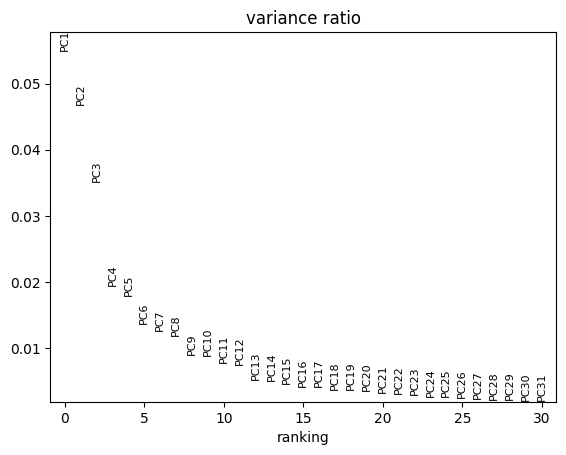

In [45]:
sc.pl.pca_variance_ratio(combined_adata)

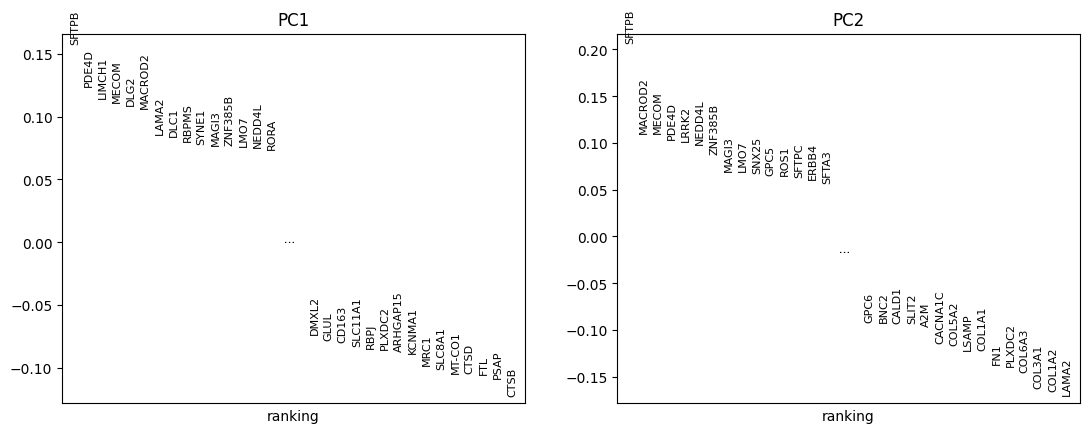

In [46]:
sc.pl.pca_loadings(combined_adata, components = '1,2');

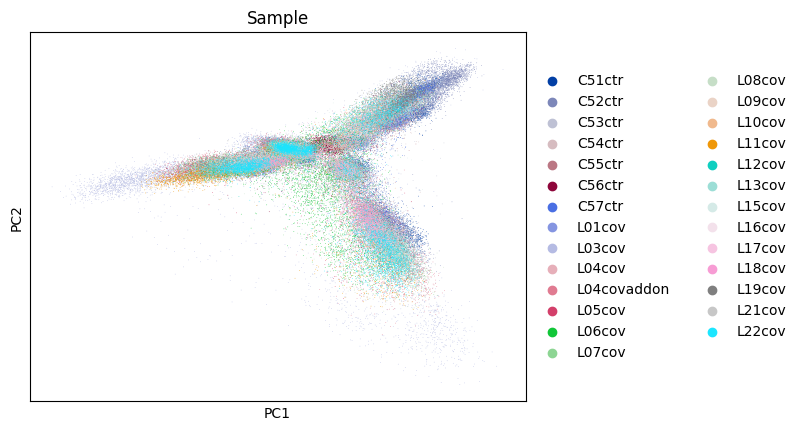

In [49]:
# Visualize
sc.pl.pca_scatter(combined_adata, color="Sample")

In [50]:
# Apply tSNE
sc.tl.tsne(combined_adata, use_rep="X_pca")
combined_adata

AnnData object with n_obs × n_vars = 116145 × 14355
    obs: 'Sample', 'Group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'counts'

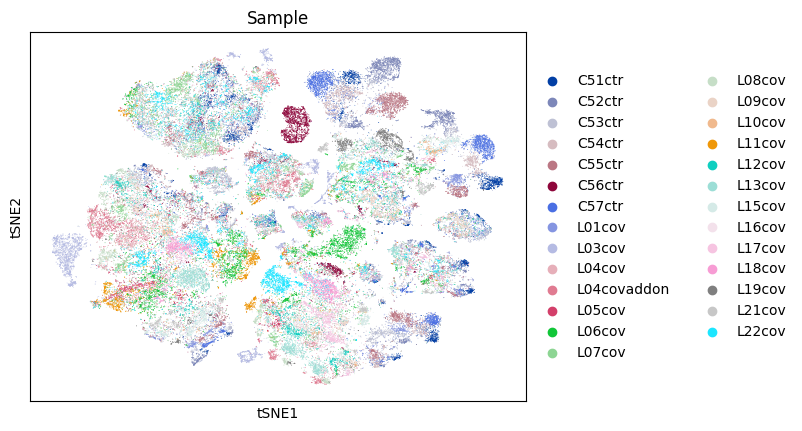

In [51]:
# Visualize tSNE
sc.pl.tsne(combined_adata, color="Sample")

In [52]:
# UMAP
sc.pp.neighbors(combined_adata)
sc.tl.umap(combined_adata)
combined_adata

c:\Users\Owner\Documents\GitHub\scRNA_Lethal_Covid19_Analysis\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


AnnData object with n_obs × n_vars = 116145 × 29602
    obs: 'Sample', 'Group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca', 'Sample_colors', 'tsne', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

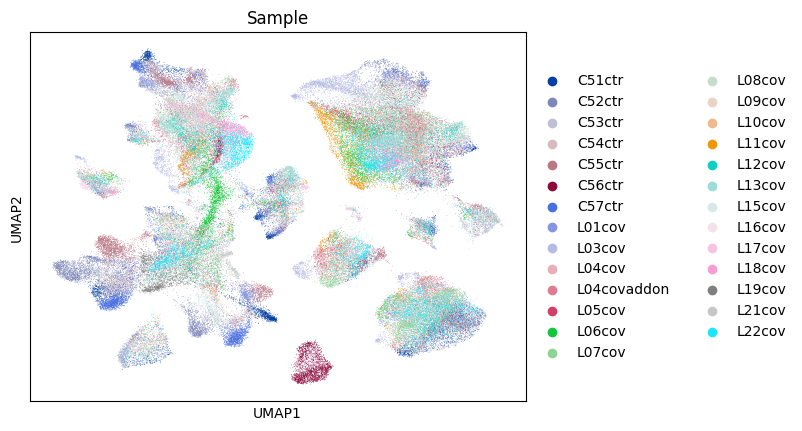

In [53]:
# Plot
sc.pl.umap(combined_adata, color="Sample")

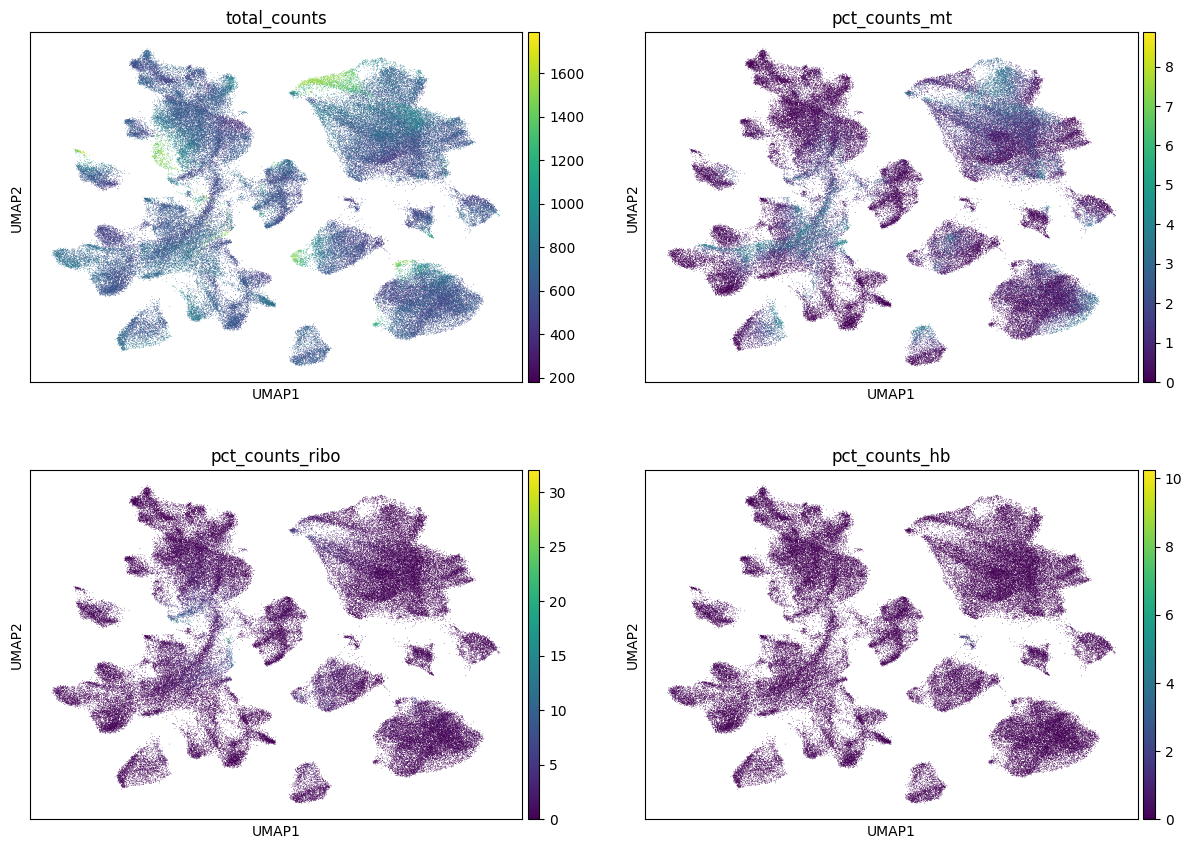

In [54]:
# Inspect quality control 
sc.pl.umap(
    combined_adata,
    color=["total_counts", "pct_counts_mt", "pct_counts_ribo", "pct_counts_hb"],
    ncols=2
)

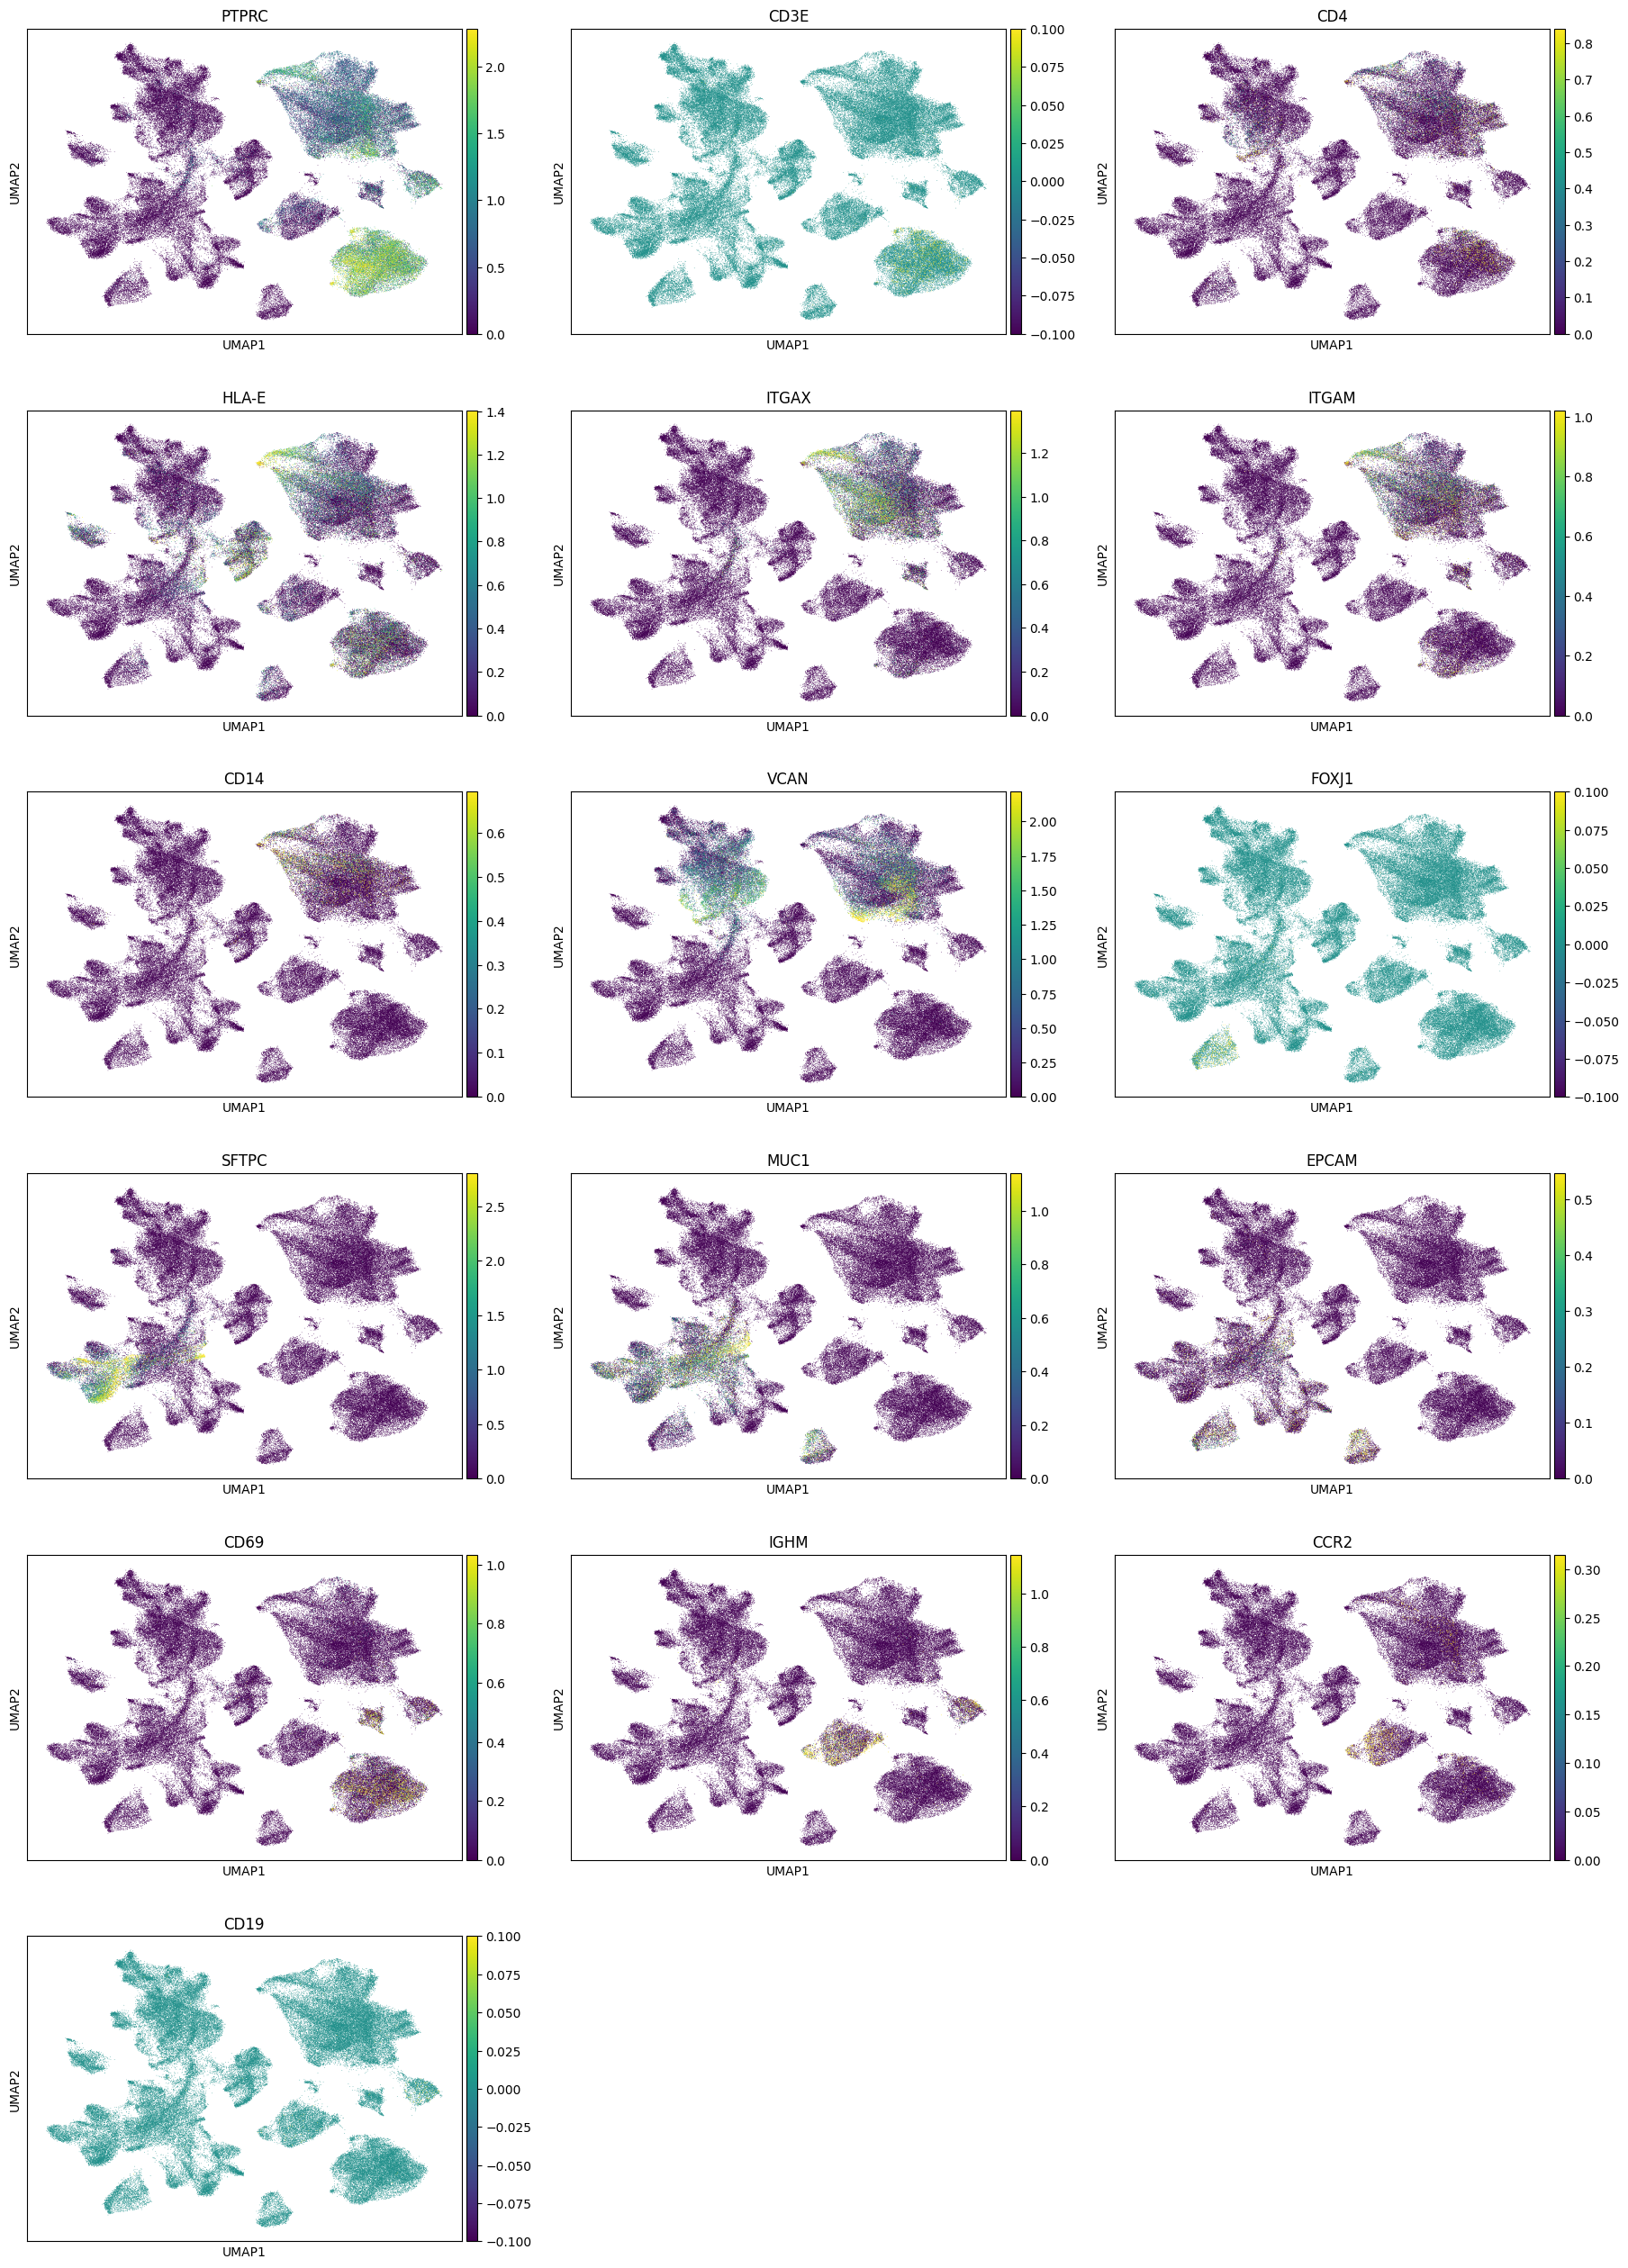

In [61]:
# Common markers List to compare feature selection methods
markers = ["PTPRC", "CD3E", "CD4", "HLA-E", "ITGAX", "ITGAM", "CD14", "VCAN", "FOXJ1", "SFTPC", "MUC1", "EPCAM", "CD69", "IGHM", "CCR2", "CD19"]

# Color by chosen markers
sc.pl.umap(combined_adata, color=markers, ncols=3, vmin=0, vmax="p99")

In [57]:
# Call Leiden algoritm with various resolutions 
for res in [0.02, 0.5, 1.0, 2.0]:
    sc.tl.leiden(
        combined_adata, key_added=f"leiden_res_{res:4.2f}", resolution=res) # flavor="igraph", n_iterations=2)
    
combined_adata

C:\Users\Owner\AppData\Local\Temp\ipykernel_9840\3017630334.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(


AnnData object with n_obs × n_vars = 116145 × 29602
    obs: 'Sample', 'Group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'leiden_res_0.02', 'leiden_res_0.50', 'leiden_res_1.00', 'leiden_res_2.00'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca', 'Sample_colors', 'tsne', 'neighbors', 'umap', 'leiden_res_0.02', 'leiden_res_0.50', 'leiden_res_1.00', 'leiden_res_2.00'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

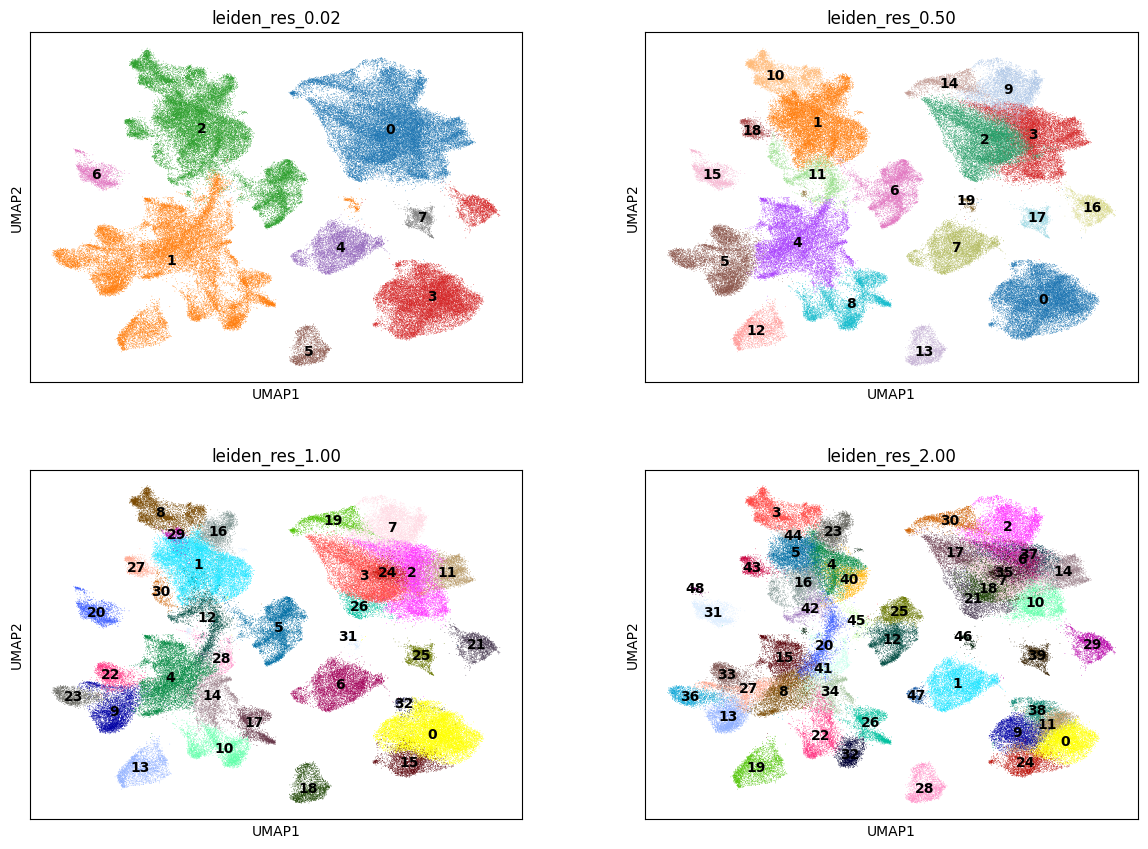

In [58]:
# Visualize outputs
sc.pl.umap(
    combined_adata,
    color=["leiden_res_0.02", "leiden_res_0.50", "leiden_res_1.00", "leiden_res_2.00"],
    legend_loc="on data",
    ncols=2
)

# Save Object

In [62]:
combined_adata

AnnData object with n_obs × n_vars = 116145 × 29602
    obs: 'Sample', 'Group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'leiden_res_0.02', 'leiden_res_0.50', 'leiden_res_1.00', 'leiden_res_2.00'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca', 'Sample_colors', 'tsne', 'neighbors', 'umap', 'leiden_res_0.02', 'leiden_res_0.50', 'leiden_res_1.00', 'leiden_res_2.00', 'leiden_res_0.02_colors', 'leiden_res_0.50_colors', 'leiden_res_1.00_colors', 'leiden_res_2.00_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'cou

In [63]:
# Save object
# combined_adata.write("data/COVID19_Integrated_Draft1.h5ad")

# End Session

In [24]:
import session_info
session_info.show()

c:\Users\Owner\Documents\GitHub\scRNA_Lethal_Covid19_Analysis\.venv\Lib\site-packages\session_info\main.py:213: UserWarning: The '__version__' attribute is deprecated and will be removed in MarkupSafe 3.1. Use feature detection, or `importlib.metadata.version("markupsafe")`, instead.
  mod_version = _find_version(mod.__version__)
